# Le Miel et les Abeilles : Algorithme Génétique

In [29]:
# Importation des librairies
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv('abeilles.csv')
# Ajouter la position de la ruche
position_ruche = pd.DataFrame({'x': [500], 'y': [500]})
df = pd.concat([position_ruche, df], ignore_index=True)



## Création de la classe 

In [31]:
import numpy as np
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import time

class GeneticAlgorithm:
    unique_id = 0

    def __init__(self, population_size, df, method='top_parents', crossover_method='crossover', mutation_method='inversion', seed=42):
        self.population_size = population_size
        self.df = df
        self.seed = seed
        self.abeille_counter = 0  # Compteur d'abeilles pour générer des IDs uniques
        self.parcours_abeilles = self.initialize_population()
        self.dist_mat = self.calculate_distance_matrix()
        self.method = method
        self.crossover_method = crossover_method
        self.mutation_method = mutation_method
        self.parents_ids = {}  # Dictionnaire pour répertorier les IDs des parents

    @classmethod
    def generate_unique_id(cls):
        cls.unique_id += 1
        return cls.unique_id

    def initialize_population(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        parcours_abeilles = []
        for _ in range(self.population_size):
            parcours = list(range(1, len(self.df)))  # Commence à partir de 1
            np.random.shuffle(parcours)
            if 0 not in parcours:
                parcours = [0] + parcours  # Ajoute 0 au début du parcours
                abeille_id = self.generate_unique_id()
                parcours_abeilles.append((abeille_id, self.ajuster_parcours(parcours)))
            else:
                abeille_id = self.generate_unique_id()
                parcours_abeilles.append((abeille_id, self.ajuster_parcours(parcours)))
        return parcours_abeilles
    
    def get_parents_ids(self):
        return self.parents_ids
    
    def ajuster_parcours(self, parcours):
        position_ruche = parcours.index(0)
        return parcours[position_ruche:] + parcours[:position_ruche]

    def total_distance(self, order):
        distances = [self.dist_mat[order[i], order[(i + 1) % len(order)]] for i in range(len(order))]
        return sum(distances)

    def calculate_distance_matrix(self):
        A = np.array(self.df)
        B = A.copy()
        return distance_matrix(A, B, p=2)

    def crossover_two_points(self, parent1, parent2):
        point1, point2 = 1, 49  # Indices de coupure arbitraires
        child1 = [0] + parent1[point1:point2]
        child2 = [0] + parent2[point1:point2]

        remaining_parent1 = [gene for gene in parent2 if gene not in child1]
        remaining_parent2 = [gene for gene in parent1 if gene not in child2]

        child1 += remaining_parent1
        child2 += remaining_parent2

        return child1, child2

    def crossover(self, parent1, parent2):
        start = np.random.randint(2, len(parent1))  # Démarre à partir de 2 pour exclure la ruche
        end = np.random.randint(start, len(parent1))
        child = [0] + [None] * (len(parent1) - 1)
        for i in range(start, end):
            child[i] = parent1[i]
        idx = 1
        for i in range(len(parent2)):
            if parent2[i] not in child:
                while child[idx] is not None:
                    idx += 1
                child[idx] = parent2[i]
        return child

    def top_parents_selection(self, num_parents=50):
        sorted_population = sorted(self.parcours_abeilles, key=lambda x: self.total_distance(x[1]))
        return sorted_population[:num_parents]

    def tournament_selection(self, k=5):
        indices = np.random.choice(len(self.parcours_abeilles), size=k, replace=False)
        candidates = [self.parcours_abeilles[i] for i in indices]
        winner = min(candidates, key=lambda x: self.total_distance(x[1]))
        return winner

    def roulette_wheel_selection(self):
        top_50 = self.parcours_abeilles[:50]
        total_fitness = sum([1 / self.total_distance(parcours[1]) for parcours in top_50])
        probabilities = [(1 / self.total_distance(parcours[1])) / total_fitness if total_fitness != 0 else 1/len(top_50) for parcours in top_50]
        selected_index = np.random.choice(range(len(top_50)), p=probabilities)
        return top_50[selected_index].copy()

    def mutate_swap(self, order):
        idx1, idx2 = np.random.choice(range(1, len(order)), 2, replace=False)  # Commence à partir de 1
        order[idx1], order[idx2] = order[idx2], order[idx1]
        return order

    def mutate_inversion(self, order):
        start, end = np.random.choice(range(1, len(order)), 2, replace=False)  # Commence à partir de 1
        order[start:end + 1] = order[start:end + 1][::-1]
        return order

    def mutate_insertion(self, order):
        idx1, idx2 = np.random.choice(range(1, len(order)), 2, replace=False)  # Commence à partir de 1
        city_to_insert = order[idx1]
        order.pop(idx1)
        order.insert(idx2, city_to_insert)
        return order

    def ensure_zero_first(self, order):
        zero_index = order.index(0)
        order[0], order[zero_index] = order[zero_index], order[0]
        return order
    
    def get_parents_ids(self):
        return self.parents_ids

    def hierarchy_pos(G, root=None, width=1., vert_gap=0.3, vert_loc=0, xcenter=0.5):
        pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
        return pos

    def _hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None, parsed=[]):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)

        if len(children) != 0:
            dx = width / 2
            nextx = xcenter - width / 2 - dx / 2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, vert_loc=vert_loc - vert_gap * 2, xcenter=nextx, pos=pos,
                                     parent=root, parsed=parsed)

        return pos


    def plot_genealogy(parents_ids, target_id, generations=5):
        G = nx.DiGraph()

        def add_parents_to_graph(graph, current_id, generations_left):
            if generations_left <= 0:
                return

            parents = parents_ids.get(current_id)
            if parents:
                parent1, parent2 = parents
                graph.add_edge(current_id, parent1)
                graph.add_edge(current_id, parent2)

                # Récursivement ajouter les parents
                add_parents_to_graph(graph, parent1, generations_left - 1)
                add_parents_to_graph(graph, parent2, generations_left - 1)

        add_parents_to_graph(G, target_id, generations)

        pos = hierarchy_pos(G, target_id, vert_gap=0.8)
        plt.figure(figsize=(12, 9))  # Ajustez les valeurs de largeur et hauteur selon vos besoins
        nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=600, node_color='skyblue', font_size=8, arrowsize=15)
        plt.title(f'Généalogie de l\'abeille avec ID {target_id} sur {generations} générations')
        plt.show()
        
    def run_genetic_algorithm(self, generations=800, mutation_rate=0.04,show_plot=False):
        fitness_history = []
        iteration_times = []

        best_fitness = float('inf')  # Initialise à l'infini
        stagnation_counter = 0

        for generation in range(generations):
            start_time = time.time()
            self.parcours_abeilles = sorted(self.parcours_abeilles, key=lambda x: self.total_distance(x[1]))
            new_parcours_abeilles = []

            for i in range(len(self.parcours_abeilles) // 2):
                parent1 = self.parcours_abeilles[i]
                parent2 = self.parcours_abeilles[i + 1]

                if self.method == "tournament":
                    parent1 = self.tournament_selection()
                    parent2 = self.tournament_selection()
                elif self.method == "roulette":
                    parent1 = self.roulette_wheel_selection()
                    parent2 = self.roulette_wheel_selection()
                elif self.method == "top_parents":
                    parents = self.top_parents_selection(2)
                    parent1, parent2 = parents[0], parents[1]
                else:
                    raise ValueError("Méthode de sélection des parents non valide")

                if self.crossover_method == "crossover":
                    child1 = (self.abeille_counter, self.crossover(parent1[1], parent2[1]))
                    child2 = (self.abeille_counter, self.crossover(parent2[1], parent1[1]))
                elif self.crossover_method == "crossover_two_points":
                    child1, child2 = self.crossover_two_points(parent1[1], parent2[1])
                else:
                    raise ValueError("Méthode de croisement non valide")

                if np.random.rand() < mutation_rate:
                    if self.mutation_method == "swap":
                        child1 = (self.abeille_counter, self.mutate_swap(child1[1]))
                    elif self.mutation_method == "inversion":
                        child1 = (self.abeille_counter, self.mutate_inversion(child1[1]))
                    elif self.mutation_method == "insertion":
                        child1 = (self.abeille_counter, self.mutate_insertion(child1[1]))
                    else:
                        raise ValueError("Méthode de mutation non valide")

                if np.random.rand() < mutation_rate:
                    if self.mutation_method == "swap":
                        child2 = (self.abeille_counter, self.mutate_swap(child2[1]))
                    elif self.mutation_method == "inversion":
                        child2 = (self.abeille_counter, self.mutate_inversion(child2[1]))
                    elif self.mutation_method == "insertion":
                        child2 = (self.abeille_counter, self.mutate_insertion(child2[1]))
                    else:
                        raise ValueError("Méthode de mutation non valide")

                new_parcours_abeilles.extend([child1, child2])

                # Répertorie les IDs des parents
                self.parents_ids[child1[0]] = (parent1[0], parent2[0])
                self.parents_ids[child2[0]] = (parent1[0], parent2[0])

                # Incrémente le compteur d'abeilles
                self.abeille_counter += 1

            self.parcours_abeilles = new_parcours_abeilles

            best_parcours_info = min(self.parcours_abeilles, key=lambda x: self.total_distance(x[1]))
            best_parcours_id, best_parcours = best_parcours_info[0], best_parcours_info[1]
            best_distance = self.total_distance(best_parcours)
            fitness_history.append(best_distance)

            # Vérifie la stagnation
            if best_distance >= best_fitness:
                stagnation_counter += 1
            else:
                stagnation_counter = 0
                best_fitness = best_distance

            # Applique les mutations seulement en cas de stagnation
            if stagnation_counter > 50:
                for abeille_info in self.parcours_abeilles:
                    abeille_id, parcours = abeille_info[0], abeille_info[1]
                    if np.random.rand() < mutation_rate:
                        mutated_parcours = None
                        if self.mutation_method == "swap":
                            mutated_parcours = self.mutate_swap(parcours)
                        elif self.mutation_method == "inversion":
                            mutated_parcours = self.mutate_inversion(parcours)
                        elif self.mutation_method == "insertion":
                            mutated_parcours = self.mutate_insertion(parcours)

                        if mutated_parcours is not None:
                            self.parcours_abeilles.append((self.abeille_counter, mutated_parcours))
                            self.abeille_counter += 1

            end_time = time.time()
            iteration_time = end_time - start_time
            iteration_times.append(iteration_time)

        if show_plot:
            plt.plot(fitness_history)
            plt.title(f'Evolution du fitness par génération\nSelection: {self.method}, Crossover: {self.crossover_method}, Mutation: {self.mutation_method}, Mutation Rate: {mutation_rate}')
            plt.xlabel('Génération')
            plt.ylabel('Fitness Score')
            plt.show()

        print("Meilleur parcours trouvé :", best_parcours)
        print("Distance totale :", best_distance)
        print("Temps moyen par génération :", np.mean(iteration_times))

        return best_distance, best_parcours, np.mean(iteration_times),best_parcours_info  # Retourne également le temps moyen d'itération


## Test 1 : Comparaison des différentes méthodes

In [33]:
# Initialiser le DataFrame pour stocker les résultats
all_results_df = pd.DataFrame(columns=['Method', 'Crossover Method', 'Mutation Method', 'Fitness Score', 'Best Parcours','Time per Generation'])

# Boucle sur toutes les combinaisons possibles
methods = ['tournament', 'roulette', 'top_parents']
crossover_methods = ['crossover', 'crossover_two_points']
mutation_methods = ['swap', 'inversion', 'insertion']

results_list = []

# Loop through all combinations of methods
for method in methods:
    for crossover_method in crossover_methods:
        for mutation_method in mutation_methods:
        # Initialize your genetic algorithm with the current methods and default seed=42
        # Créez une instance de la classe GeneticAlgorithm
        # Imprimez les informations de la méthode sélectionnée
            print('*'*40)
            print(f"Method: {method}, Crossover Method: {crossover_method}, Mutation Method: {mutation_method}")

            instance_genetic_algorithm = GeneticAlgorithm(population_size=100, df=df)

            # Exécutez l'algorithme génétique
            best_distance, best_parcours, mean_iteration_time,best_parcours_info = instance_genetic_algorithm.run_genetic_algorithm(generations=500, mutation_rate=0.04,show_plot=False)

            # Add results to the list
            results_list.append({
                'Method': method,
                'Crossover Method': crossover_method,
                 'Mutation Method': mutation_method,
                'Fitness Score': best_distance,
                'Best Parcours': best_parcours,
                'Time per Generation': mean_iteration_time
                })

# Create the DataFrame from the list
results_df = pd.DataFrame(results_list)

****************************************
Method: tournament, Crossover Method: crossover, Mutation Method: swap
Meilleur parcours trouvé : [0, 44, 12, 9, 16, 26, 6, 45, 17, 34, 3, 7, 19, 14, 46, 40, 27, 42, 50, 31, 28, 24, 49, 15, 18, 22, 21, 25, 29, 39, 20, 30, 13, 11, 4, 23, 38, 48, 37, 47, 33, 1, 35, 41, 2, 5, 43, 36, 8, 10, 32]
Distance totale : 8546.0
Temps moyen par génération : 0.13360412740707397
****************************************
Method: tournament, Crossover Method: crossover, Mutation Method: inversion
Meilleur parcours trouvé : [0, 6, 26, 45, 17, 19, 14, 46, 7, 3, 34, 43, 36, 5, 2, 41, 48, 37, 47, 32, 8, 10, 33, 1, 35, 38, 23, 4, 13, 11, 28, 25, 29, 39, 20, 30, 15, 49, 24, 18, 21, 22, 40, 27, 31, 42, 50, 16, 9, 44, 12]
Distance totale : 8860.0
Temps moyen par génération : 0.19498694133758546
****************************************
Method: tournament, Crossover Method: crossover, Mutation Method: insertion
Meilleur parcours trouvé : [0, 9, 44, 12, 16, 17, 45, 26, 6, 8

In [34]:
results_df.sort_values('Fitness Score')

,Method,Crossover Method,Mutation Method,Fitness Score,Best Parcours,Time per Generation
15,top_parents,crossover_two_points,swap,8150.0,"[0, 16, 9, 44, 12, 50, 31, 42, 27, 40, 46, 14,...",0.266237
16,top_parents,crossover_two_points,inversion,8184.0,"[0, 25, 22, 21, 29, 18, 20, 39, 15, 49, 24, 28...",0.617836
0,tournament,crossover,swap,8546.0,"[0, 44, 12, 9, 16, 26, 6, 45, 17, 34, 3, 7, 19...",0.133604
8,roulette,crossover,insertion,8768.0,"[0, 44, 12, 25, 22, 21, 29, 18, 39, 20, 30, 13...",0.102152
1,tournament,crossover,inversion,8860.0,"[0, 6, 26, 45, 17, 19, 14, 46, 7, 3, 34, 43, 3...",0.194987
9,roulette,crossover_two_points,swap,8894.0,"[0, 44, 12, 50, 42, 27, 40, 46, 14, 31, 9, 16,...",0.242778
3,tournament,crossover_two_points,swap,9002.0,"[0, 26, 17, 9, 16, 19, 46, 14, 27, 31, 50, 42,...",0.123335
12,top_parents,crossover,swap,9032.0,"[0, 22, 21, 29, 25, 24, 49, 15, 30, 39, 18, 20...",0.343272
4,tournament,crossover_two_points,inversion,9036.0,"[0, 22, 21, 29, 18, 20, 39, 15, 25, 49, 24, 28...",0.088091
2,tournament,crossover,insertion,9090.0,"[0, 9, 44, 12, 16, 17, 45, 26, 6, 8, 32, 47, 3...",0.129137


On remarque que la méthode de mutation 'Insertion' et celle de sélection 'Roulette' ne permettent pas d'optimiser le Fitness Score.  
Je les retire et recommence le test.

## Comparaison des méthodes retenues

In [36]:
# Boucle sur toutes les combinaisons possibles
methods = ['tournament', 'top_parents']
crossover_methods = ['crossover', 'crossover_two_points']
mutation_methods = ['inversion', 'swap']

results_list_2 = []

# Loop through all combinations of methods
for method in methods:
    for crossover_method in crossover_methods:
        for mutation_method in mutation_methods:
            print('*'*40)
            print(f"Method: {method}, Crossover Method: {crossover_method}, Mutation Method: {mutation_method}")
            # Créez une instance de la classe GeneticAlgorithm
            instance_genetic_algorithm = GeneticAlgorithm(population_size=100, df=df)

            # Exécutez l'algorithme génétique
            best_distance, best_parcours,mean_iteration_time,best_parcours_info = instance_genetic_algorithm.run_genetic_algorithm(generations=500, mutation_rate=0.04,show_plot=False)
            
            # Add results to the list
            results_list_2.append({
                'Method': method,
                'Crossover Method': crossover_method,
                'Mutation Method': mutation_method,
                'Fitness Score': best_distance,
                'Best Parcours': best_parcours,
                'Time per Generation': mean_iteration_time
            })

# Create the DataFrame from the list
results_df_2 = pd.DataFrame(results_list_2)

****************************************
Method: tournament, Crossover Method: crossover, Mutation Method: inversion
Meilleur parcours trouvé : [0, 22, 21, 29, 25, 12, 44, 28, 11, 39, 20, 18, 24, 49, 15, 30, 13, 4, 23, 48, 38, 35, 41, 2, 37, 1, 47, 32, 10, 33, 5, 43, 36, 8, 3, 34, 7, 46, 14, 19, 16, 9, 50, 42, 40, 27, 31, 17, 45, 26, 6]
Distance totale : 9340.0
Temps moyen par génération : 0.2094715723991394
****************************************
Method: tournament, Crossover Method: crossover, Mutation Method: swap
Meilleur parcours trouvé : [0, 6, 8, 34, 2, 5, 43, 36, 3, 7, 16, 17, 45, 26, 9, 50, 31, 27, 19, 14, 46, 40, 42, 22, 21, 29, 25, 44, 12, 28, 24, 49, 18, 20, 39, 15, 13, 30, 11, 4, 48, 38, 23, 41, 35, 1, 33, 37, 47, 10, 32]
Distance totale : 9408.0
Temps moyen par génération : 0.09069633483886719
****************************************
Method: tournament, Crossover Method: crossover_two_points, Mutation Method: inversion
Meilleur parcours trouvé : [0, 44, 12, 50, 42, 27, 3

In [37]:
results_df_2.sort_values('Fitness Score')

,Method,Crossover Method,Mutation Method,Fitness Score,Best Parcours,Time per Generation
4,top_parents,crossover,inversion,8552.0,"[0, 8, 32, 47, 10, 33, 1, 38, 37, 48, 4, 23, 3...",0.211919
2,tournament,crossover_two_points,inversion,8816.0,"[0, 44, 12, 50, 42, 27, 31, 9, 16, 26, 6, 45, ...",0.462012
7,top_parents,crossover_two_points,swap,9104.0,"[0, 47, 10, 32, 8, 36, 43, 5, 2, 33, 37, 1, 41...",0.108126
0,tournament,crossover,inversion,9340.0,"[0, 22, 21, 29, 25, 12, 44, 28, 11, 39, 20, 18...",0.209472
1,tournament,crossover,swap,9408.0,"[0, 6, 8, 34, 2, 5, 43, 36, 3, 7, 16, 17, 45, ...",0.090696
3,tournament,crossover_two_points,swap,9428.0,"[0, 44, 12, 6, 26, 32, 43, 2, 5, 36, 8, 34, 3,...",0.112782
5,top_parents,crossover,swap,9566.0,"[0, 6, 8, 36, 43, 5, 2, 33, 10, 1, 11, 28, 24,...",0.153756
6,top_parents,crossover_two_points,inversion,9870.0,"[0, 6, 10, 43, 5, 2, 41, 13, 30, 20, 39, 22, 2...",0.094105


## Test 2 : Modification du taux de mutation

In [38]:
# Boucle sur toutes les combinaisons possibles
methods = ['tournament', 'top_parents']
crossover_methods = ['crossover', 'crossover_two_points']
mutation_methods = ['inversion']

mutation_list = []

mutation_rates = [0.02, 0.04, 0.05, 0.07]

# Loop through all combinations of methods and mutation rates
for method in methods:
    for crossover_method in crossover_methods:
        for mutation_method in mutation_methods:
            for mutation_rate in mutation_rates:
                # Initialize your genetic algorithm with the current methods and mutation rate
                instance_genetic_algorithm = GeneticAlgorithm(population_size=100, df=df)

            # Exécutez l'algorithme génétique
                best_distance, best_parcours,mean_iteration_time,best_parcours_info = instance_genetic_algorithm.run_genetic_algorithm(generations=500, mutation_rate=mutation_rate,show_plot=False)
            
                # Add results to the list
                mutation_list.append({
                    'Method': method,
                    'Crossover Method': crossover_method,
                    'Mutation Method': mutation_method,
                    'Mutation Rate': mutation_rate,
                    'Fitness Score': best_distance,
                    'Best Parcours': best_parcours,
                    'Time per Generation': mean_iteration_time
                })


Meilleur parcours trouvé : [0, 25, 21, 29, 22, 12, 50, 40, 27, 42, 31, 16, 9, 26, 45, 17, 19, 14, 46, 3, 7, 34, 36, 43, 2, 5, 33, 10, 47, 28, 24, 18, 20, 39, 15, 49, 30, 13, 23, 35, 1, 41, 38, 4, 11, 48, 37, 32, 8, 6, 44]
Distance totale : 9994.0
Temps moyen par génération : 0.08940160417556763
Meilleur parcours trouvé : [0, 44, 12, 16, 17, 34, 7, 3, 31, 50, 42, 25, 29, 49, 24, 15, 30, 13, 11, 4, 48, 23, 38, 37, 1, 35, 41, 2, 33, 5, 43, 36, 8, 32, 10, 47, 28, 39, 20, 18, 21, 22, 40, 27, 14, 46, 19, 9, 45, 26, 6]
Distance totale : 9650.0
Temps moyen par génération : 0.10932142353057861
Meilleur parcours trouvé : [0, 6, 34, 3, 36, 43, 5, 2, 1, 35, 41, 23, 38, 48, 37, 49, 15, 11, 4, 13, 30, 20, 39, 29, 25, 44, 12, 9, 16, 26, 45, 17, 7, 19, 46, 14, 31, 50, 42, 27, 40, 22, 21, 18, 24, 28, 47, 33, 10, 32, 8]
Distance totale : 9006.0
Temps moyen par génération : 0.20652734184265137
Meilleur parcours trouvé : [0, 6, 26, 45, 16, 9, 44, 12, 50, 31, 42, 27, 40, 14, 46, 19, 17, 7, 3, 34, 36, 43, 5

In [39]:
# Create the DataFrame from the list
mutation_rate = pd.DataFrame(mutation_list)

mutation_rate.sort_values('Fitness Score')


,Method,Crossover Method,Mutation Method,Mutation Rate,Fitness Score,Best Parcours,Time per Generation
3,tournament,crossover,inversion,0.07,7866.0,"[0, 6, 26, 45, 16, 9, 44, 12, 50, 31, 42, 27, ...",0.259246
15,top_parents,crossover_two_points,inversion,0.07,8342.0,"[0, 44, 12, 25, 24, 28, 37, 38, 35, 41, 23, 48...",0.228690
5,tournament,crossover_two_points,inversion,0.04,8636.0,"[0, 6, 47, 10, 32, 8, 36, 43, 5, 2, 33, 1, 37,...",0.642522
11,top_parents,crossover,inversion,0.07,8656.0,"[0, 6, 44, 12, 50, 31, 27, 42, 25, 24, 28, 37,...",0.159363
7,tournament,crossover_two_points,inversion,0.07,8782.0,"[0, 25, 22, 29, 21, 40, 46, 14, 19, 16, 17, 50...",0.079997
13,top_parents,crossover_two_points,inversion,0.04,8876.0,"[0, 6, 26, 45, 16, 17, 7, 34, 3, 19, 14, 46, 3...",0.241645
14,top_parents,crossover_two_points,inversion,0.05,8974.0,"[0, 32, 8, 26, 6, 47, 48, 23, 38, 35, 41, 1, 3...",0.086779
2,tournament,crossover,inversion,0.05,9006.0,"[0, 6, 34, 3, 36, 43, 5, 2, 1, 35, 41, 23, 38,...",0.206527
10,top_parents,crossover,inversion,0.05,9036.0,"[0, 44, 12, 28, 24, 49, 15, 30, 11, 4, 13, 39,...",0.111507
6,tournament,crossover_two_points,inversion,0.05,9040.0,"[0, 8, 32, 45, 16, 9, 50, 31, 27, 14, 46, 40, ...",0.113162


D'après ce tableau, les méthodes les plus performantes sont :  
Sélection : **Tournament**  
Croisement: **Crossover**  
Mutation : **Inversion**  
Taux de mutation : **0.07**

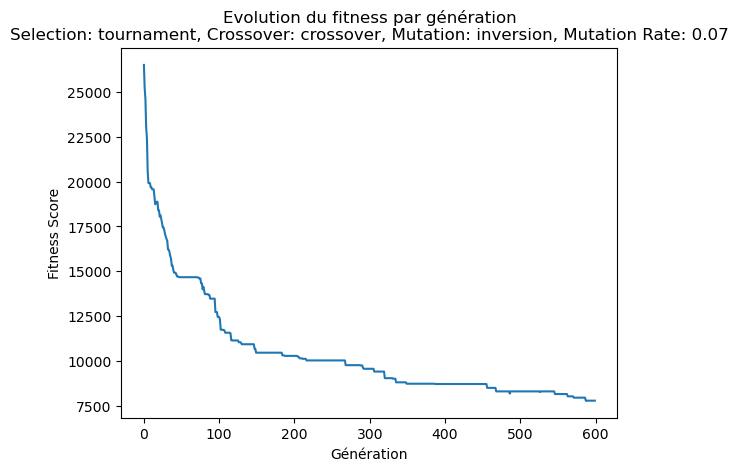

Meilleur parcours trouvé : [0, 32, 8, 7, 3, 34, 36, 43, 5, 2, 33, 10, 47, 37, 1, 41, 35, 38, 48, 23, 4, 11, 13, 30, 15, 39, 20, 18, 21, 22, 29, 25, 49, 24, 28, 12, 44, 9, 16, 19, 14, 46, 40, 27, 42, 31, 50, 17, 45, 26, 6]
Distance totale : 7776.0
Temps moyen par génération : 0.03509205420811971


In [43]:
instance_genetic_algorithm = GeneticAlgorithm(population_size=100, df=df,method='tournament', crossover_method='crossover', mutation_method='inversion', seed=42)
best_distance, best_parcours,mean_iteration_time,best_parcours_info = instance_genetic_algorithm.run_genetic_algorithm(generations=600, mutation_rate=0.07,show_plot=True)

In [44]:
# Obtenez le dictionnaire des IDs des parents
parents_ids = instance_genetic_algorithm.get_parents_ids()
print(best_parcours_info[0])

62251


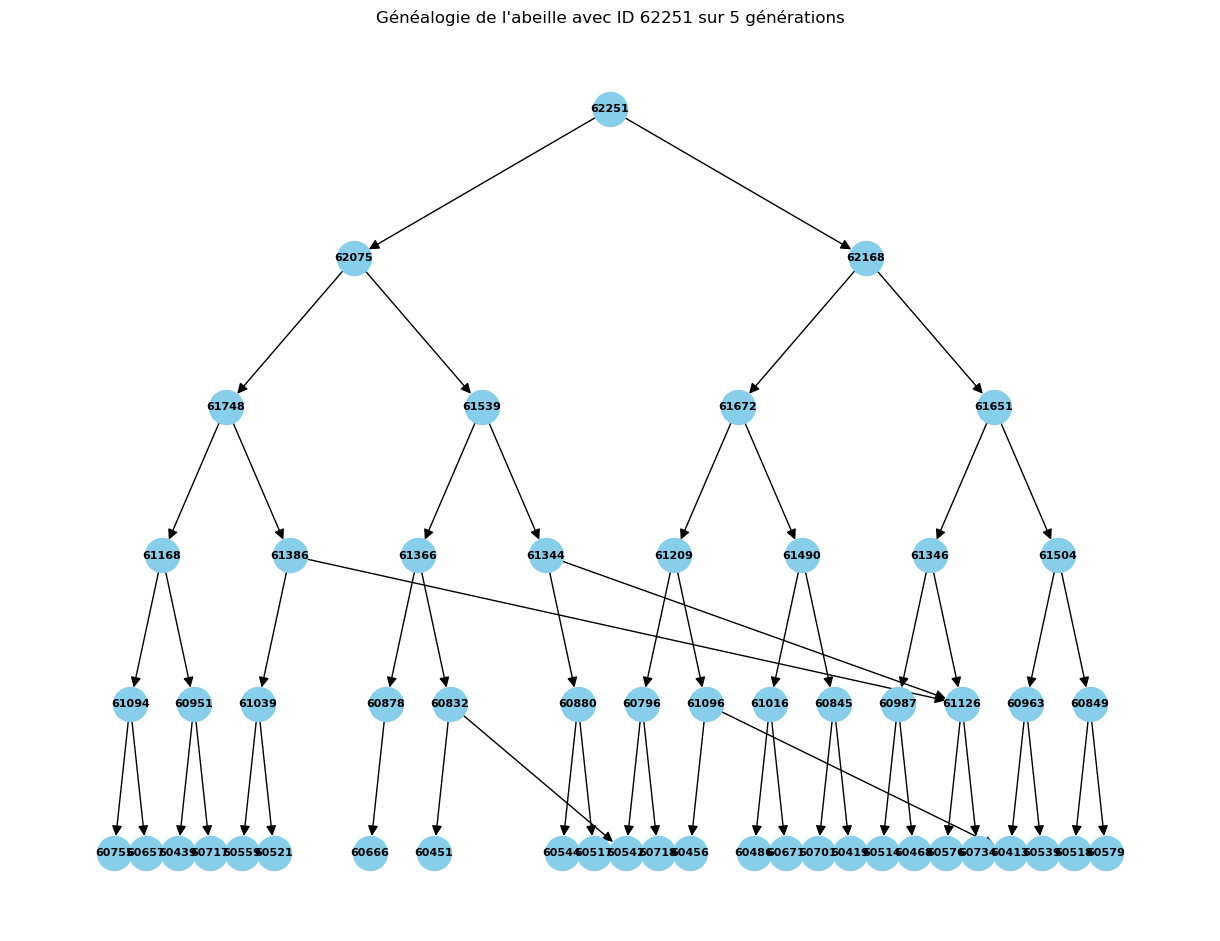

In [45]:
import matplotlib.pyplot as plt
import networkx as nx

def hierarchy_pos(G, root=None, width=1., vert_gap=0.3, vert_loc=0, xcenter=0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos

def _hierarchy_pos(G, root, width=1., vert_gap=0.2, vert_loc=0, xcenter=0.5, pos=None, parent=None, parsed=[]):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)
    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)

    if len(children) != 0:
        dx = width / 2
        nextx = xcenter - width / 2 - dx / 2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, vert_loc=vert_loc - vert_gap * 2, xcenter=nextx, pos=pos,
                                 parent=root, parsed=parsed)

    return pos


def plot_genealogy(parents_ids, target_id, generations=5):
    G = nx.DiGraph()

    def add_parents_to_graph(graph, current_id, generations_left):
        if generations_left <= 0:
            return

        parents = parents_ids.get(current_id)
        if parents:
            parent1, parent2 = parents
            graph.add_edge(current_id, parent1)
            graph.add_edge(current_id, parent2)

            # Récursivement ajouter les parents
            add_parents_to_graph(graph, parent1, generations_left - 1)
            add_parents_to_graph(graph, parent2, generations_left - 1)

    add_parents_to_graph(G, target_id, generations)

    pos = hierarchy_pos(G, target_id, vert_gap=0.8)
    plt.figure(figsize=(12, 9))  # Ajustez les valeurs de largeur et hauteur selon vos besoins
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=600, node_color='skyblue', font_size=8, arrowsize=15)
    plt.title(f'Généalogie de l\'abeille avec ID {target_id} sur {generations} générations')
    plt.show()


# Utilisez la meilleure abeille obtenue (assurez-vous d'avoir exécuté votre algorithme au moins 10 générations)
best_abeille_id = best_parcours_info[0]
plot_genealogy(parents_ids, best_abeille_id, generations=5)



## Algorithme de Dijkstra

In [46]:
# Importation des librairies
import numpy as np
import pandas as pd
from scipy import spatial
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import networkx as nx
import itertools

In [47]:
#population_size = 100
df1 = pd.read_csv('abeilles.csv')
#np.random.seed(42)
# Ajouter la position de la ruche
position_ruche = pd.DataFrame({'x': [500], 'y': [500]})
df1 = pd.concat([position_ruche, df1], ignore_index=True)



In [48]:
# Ajouter la ruche au début du DataFrame
df.index = df.index + 1
df = df.sort_index()

# Calculer la matrice de distance
dist_matrix = distance_matrix(df.values, df.values)

# Créer un graphe à partir de la matrice de distance
graph = nx.from_numpy_array(dist_matrix)

# Trouver le parcours le plus court (TSP)
tsp_path = list(nx.approximation.traveling_salesman_problem(graph))

# Calculer le fitness score (distance totale)
fitness_score = sum(dist_matrix[tsp_path[i], tsp_path[i + 1]] for i in range(len(tsp_path) - 1))

# Afficher le parcours et le fitness score
print("Parcours le plus court (indices) :", tsp_path)
print("Fitness Score (distance totale) :", fitness_score)

# Afficher les coordonnées des fleurs dans l'ordre du parcours
tsp_coordinates = df.iloc[tsp_path]

Parcours le plus court (indices) : [0, 6, 32, 10, 8, 36, 43, 5, 2, 33, 47, 37, 1, 38, 48, 23, 41, 35, 4, 11, 13, 30, 15, 28, 24, 49, 39, 20, 18, 29, 22, 21, 25, 12, 44, 9, 50, 31, 42, 27, 40, 14, 46, 19, 3, 34, 7, 17, 45, 26, 16, 0]
Fitness Score (distance totale) : 6595.158737496084
